# analysis of altimetric data

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#from h3 import h3

#import pyinterp

import pytide

from xhistogram.xarray import histogram

In [4]:
plt_params = {'extent':[-75,20,-70,70],
              'dticks':[20,20],
              'projection': ccrs.PlateCarree(0)}
#              'projection': ccrs.Robinson(central_longitude=-30)}
#              'projection': ccrs.Mollweide()}

In [5]:
def plot(v, vmin=None, vmax=None, x='longitude_bin', y='latitude_bin', 
         figsize=(10,10), colorbar=True, colmap=None, colorbar_kwargs={}):
    _projection = plt_params['projection']
    _extent = plt_params['extent']
    _dticks = plt_params['dticks']
    #
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=_projection)
    ax.set_extent(_extent)
    im = v.plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x=x, y=y, cmap=colmap, add_colorbar=False)
    if colorbar:
        cbar = fig.colorbar(im, **colorbar_kwargs)
    else:
        cbar = None
    # grid lines:
    xticks = np.arange(_extent[0],
                       _extent[1]+_dticks[0],
                       _dticks[1]*np.sign(_extent[1]-_extent[0]))
    ax.set_xticks(xticks,crs=ccrs.PlateCarree())
    yticks = np.arange(_extent[2],
                       _extent[3]+_dticks[1],
                       _dticks[1]*np.sign(_extent[3]-_extent[2]))
    ax.set_yticks(yticks,crs=ccrs.PlateCarree())
    gl = ax.grid()
    ax.add_feature(cfeature.LAND)
    #
    #if title is not None:
    #    ax.set_title(title,fontdict={'fontsize':20, 'fontweight':'bold'})

---

## not used for now

In [6]:
from dask.distributed import Client
client = Client()
client

/home1/homedir5/perso/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:56171 Dashboard: http://127.0.0.1:45918/status,Cluster Workers: 4 Cores: 8 Memory: 33.66 GB


In [12]:
#from dask_kubernetes import KubeCluster
#cluster = KubeCluster()
#cluster.adapt(minimum=1, maximum=10)

In [ ]:
#cluster

---

## load data

In [7]:
# if on local computer:
ds = xr.open_zarr('/home2/pharos/othr/aponte/alti/tp')

In [8]:
# if on cloud:
#import gcsfs.mapping
#fs = gcsfs.GCSFileSystem(project='pangeo-cnes', token=None)
#gcsmap = gcsfs.mapping.GCSMap('pangeo-cnes/alti/tp', gcs=fs)
#ds = xr.open_zarr(gcsmap, consolidated=True)

In [9]:
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))
ds0 = ds
ds

Dataset size = 8.8 GB


<xarray.Dataset>
Dimensions:         (time: 157384325)
Coordinates:
    latitude        (time) float64 dask.array<shape=(157384325,), chunksize=(1000000,)>
    longitude       (time) float64 dask.array<shape=(157384325,), chunksize=(1000000,)>
  * time            (time) datetime64[ns] 1993-03-02T23:44:00.992296960 ... 2002-01-03T23:20:19.861993216
Data variables:
    cycle           (time) int16 dask.array<shape=(157384325,), chunksize=(1000000,)>
    dac             (time) float32 dask.array<shape=(157384325,), chunksize=(1000000,)>
    lwe             (time) float32 dask.array<shape=(157384325,), chunksize=(1000000,)>
    mdt             (time) float32 dask.array<shape=(157384325,), chunksize=(1000000,)>
    ocean_tide      (time) float64 dask.array<shape=(157384325,), chunksize=(1000000,)>
    sla_filtered    (time) float32 dask.array<shape=(157384325,), chunksize=(1000000,)>
    sla_unfiltered  (time) float32 dask.array<shape=(157384325,), chunksize=(1000000,)>
    track           

In [12]:
ds.time[0]

<xarray.DataArray 'time' ()>
array('1993-03-02T23:44:00.992296960', dtype='datetime64[ns]')
Coordinates:
    latitude   float64 dask.array<shape=(), chunksize=()>
    longitude  float64 dask.array<shape=(), chunksize=()>
    time       datetime64[ns] 1993-03-02T23:44:00.992296960
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

In [11]:
ds.time[-1]

<xarray.DataArray 'time' ()>
array('2002-01-03T23:20:19.861993216', dtype='datetime64[ns]')
Coordinates:
    latitude   float64 dask.array<shape=(), chunksize=()>
    longitude  float64 dask.array<shape=(), chunksize=()>
    time       datetime64[ns] 2002-01-03T23:20:19.861993216
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

### description of each variables

<img src="capture.png">

- SSH : Sea Surface Height
- MDT : Mean Dynamic Topography (temporal mean of the SSH above the Geoid over a period N)
- MSS : Mean Sea Surface (temporal mean of the SSH over a period N)
- SLA : Sea Level Anomaly deduced from the SSH using a MMS
- dac : Dynamic Atmospheric correction
- sla_filtered : Sea level anomaly
- sla_unfiltered : Sea level anomaly


---

## xhistogram 

In [41]:
ds = ds0
ds = ds0.isel(time=slice(0,int(1e7))) # à commenter à terme
ds['longitude'] = (ds.longitude+180)%360 - 180
ds = ds.where((ds.longitude<10)&(ds.longitude>-70), drop=True)

In [19]:
lon_bins = np.arange(-70, 10, 1)
lat_bins = np.arange(-70, 70, 1)

N = (histogram(ds.longitude, ds.latitude, bins=[lon_bins, lat_bins])
     .where(N>0)
     .persist()
    )

sla_mean = (histogram(ds.longitude, ds.latitude, 
                      bins=[lon_bins, lat_bins], weights=ds.sla_filtered)/N) \
            .rename('sla_mean').persist()

sla2_mean = (histogram(ds.longitude, ds.latitude, 
                       bins=[lon_bins, lat_bins], weights=ds.sla_filtered**2)/N)\
            .rename('sla2_mean').persist()

In [20]:
sla_mean

<xarray.DataArray 'sla_mean' (longitude_bin: 79, latitude_bin: 139)>
dask.array<shape=(79, 139), dtype=float64, chunksize=(79, 139)>
Coordinates:
  * longitude_bin  (longitude_bin) float64 -69.5 -68.5 -67.5 ... 6.5 7.5 8.5
  * latitude_bin   (latitude_bin) float64 -69.5 -68.5 -67.5 ... 66.5 67.5 68.5

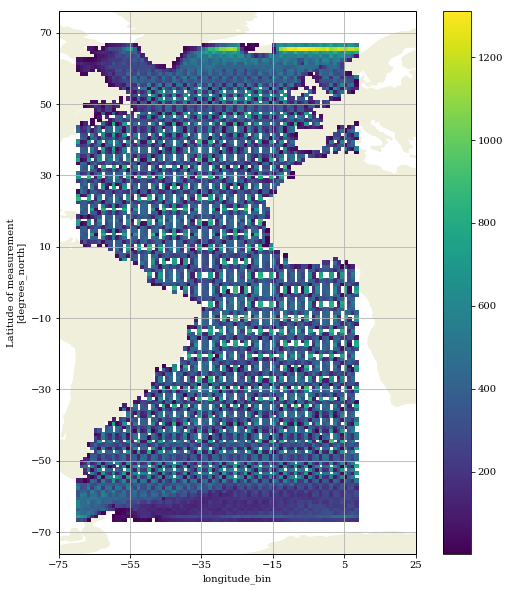

In [21]:
plot(N)

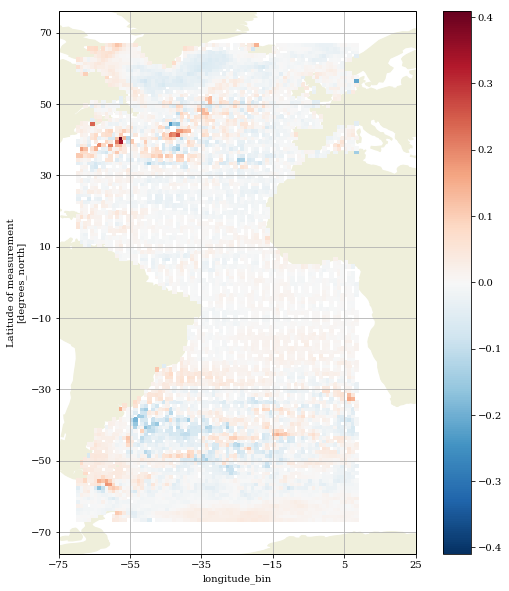

In [22]:
plot(sla_mean)

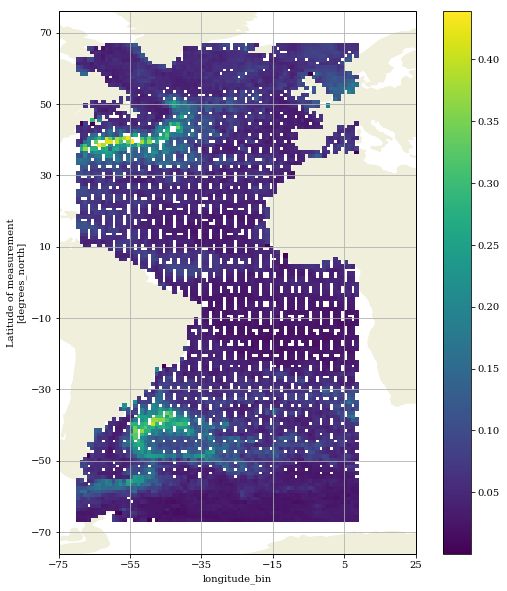

In [23]:
plot(np.sqrt(sla2_mean-sla_mean**2))

## what's next

- calculer le niveau de bruit à partir de la formule analytique et afficher

- extraire les harmoniques de marée

In [42]:
ddf = ds.isel(time=slice(0,int(1e6))).to_dask_dataframe().persist()
ddf.head()

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track
npartitions=5,,,,,,,,,,,
0,datetime64[ns],float64,float64,float64,float32,float32,float32,float64,float32,float32,float64
241656,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
975974,...,...,...,...,...,...,...,...,...,...,...
999999,...,...,...,...,...,...,...,...,...,...,...


In [43]:
# need wrapper around groupped data
lon_bins = np.arange(-70, 10, 1)
lat_bins = np.arange(-70, 70, 1)

# bin and apply tidal computation
lon_idx = pd.IntervalIndex.from_breaks(lon_bins)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
ddf['lon_cut'] = ddf['longitude'].map_partitions(pd.cut, bins=lon_bins)
ddf['lat_cut'] = ddf['latitude'].map_partitions(pd.cut, bins=lat_bins)

In [44]:
df = ddf.groupby(['lon_cut','lat_cut']).get_group((lon_idx[35], lat_idx[100])).compute()
df.head()

In [46]:
df.head()

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track,lon_cut,lat_cut
45850,1993-07-31 22:27:06.225328128,30.575835,-34.983226,32.0,-0.1395,0.005,0.367,0.1472,0.025,0.028,113.0,"(-35, -34]","(30, 31]"
45851,1993-07-31 22:27:07.303908096,30.626716,-34.956293,32.0,-0.1398,0.005,0.366,0.1474,0.021,0.035,113.0,"(-35, -34]","(30, 31]"
45852,1993-07-31 22:27:08.382488064,30.677589,-34.929328,32.0,-0.1400,0.005,0.365,0.1474,0.016,0.045,113.0,"(-35, -34]","(30, 31]"
45853,1993-07-31 22:27:09.461068032,30.728454,-34.902330,32.0,-0.1403,0.005,0.364,0.1474,0.010,0.014,113.0,"(-35, -34]","(30, 31]"
45854,1993-07-31 22:27:10.539648000,30.779311,-34.875298,32.0,-0.1406,0.005,0.363,0.1475,0.004,-0.011,113.0,"(-35, -34]","(30, 31]"


In [26]:
ddf.head()

,time,latitude,longitude,cycle,dac,lwe,mdt,ocean_tide,sla_filtered,sla_unfiltered,track,lon_cut,lat_cut
0,1993-03-02 23:44:00.992296960,-65.755172,313.897179,17,0.2177,-0.003,-1.416,0.3507,-0.002,-0.043,57,NaN,"(-66, -65]"
1,1993-03-02 23:44:02.070876928,-65.745171,314.029894,17,0.2179,-0.003,-1.419,0.3488,0.004,-0.002,57,NaN,"(-66, -65]"
2,1993-03-02 23:44:03.149456896,-65.735048,314.162501,17,0.2181,-0.003,-1.421,0.3468,0.009,0.023,57,NaN,"(-66, -65]"
3,1993-03-02 23:44:04.228036864,-65.724803,314.295001,17,0.2183,-0.003,-1.424,0.3448,0.013,0.027,57,NaN,"(-66, -65]"
4,1993-03-02 23:44:05.306616832,-65.714435,314.427391,17,0.2184,-0.003,-1.427,0.3428,0.016,0.031,57,NaN,"(-66, -65]"


In [59]:
def harmonic_analysis(df, ssh_key, constituents=None):

    # get group id
    try:
        dr_id = df.id.unique()[0]
    except:
        dr_id = df.name    
    
    if constituents is None:
        _cst = ["M2", "K1", "O1", "P1", "Q1", "S1"]
    else:
        _cst = constituents

    time = df['time'].to_numpy(dtype="datetime64[us]")
    wt = pytide.WaveTable(_cst)
    # compute
    f, vu = wt.compute_nodal_modulations(time)

    # get harmonics
    w = wt.harmonic_analysis(df[ssh_key].to_numpy(), f, vu)

    # predicted tidal contribution
    #hp = wt.tide_from_tide_series(time, w)
    
    out = pd.DataFrame(w, columns = _cst, index=dr_id)
    return out
    
out = harmonic_analysis(df, ssh_key='sla_unfiltered')
out

AttributeError: 'DataFrame' object has no attribute 'name'

---
## pyinterp approach

[pyinterp doc](https://pangeo-pyinterp.readthedocs.io/en/latest/examples.html)

In [9]:
ds = ds0.isel(time=slice(0,int(1e8))).chunk({'time':1e6})
#ds = ds0.where((ds.longitude<45)&(ds.longitude>-45), drop=True)
#ds = ds0 # crashes
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))

Dataset size = 5.6 GB


In [10]:
ds = ds.persist()

In [15]:
binning = pyinterp.Binning2D(
    pyinterp.Axis(np.arange(-180, 180, 1), is_circle=True),
    pyinterp.Axis(np.arange(-90, 95, 1)))

In [ ]:
#mx, my = np.meshgrid(ds.longitude, ds.latitude)
binning.push(ds.longitude, ds.latitude, ds.mdt, simple=True)

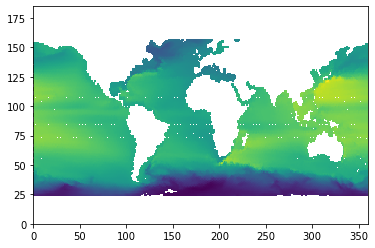

In [13]:
plt.pcolormesh(binning.variable('mean').T)

In [ ]:
binning.variable('mean')

In [1]:
np.asarray(ds.mdt).flatten().shape

NameError: name 'np' is not defined

---
## h3

In [ ]:
ds = ds.isel(time=slice(0,int(1e6)))
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))

df = ds.to_dataframe()
df

In [ ]:
resolution = 7
%time df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], resolution), axis = 1)

In [ ]:
df

In [ ]:
df_stats = df.groupby('hex_id').mean()